<h3>Determine lesion locations, GT masks, and paste lesions on the texture image</h3>

This notebook shows how to:
- determine locations to blend the lesion on the texture image
- create the corresponding lesion mask on the texture image
- paste (not blend) the 2D lesion onto the texture image
- paste (not blend) the textures surrounding the 2D lesion onto the texture image (needed to compute gradients during blending)
- perform texture padding of the texture image for both the transfered lesion and the mask (only needed if lesion occurs on a texture seam)

This notebook saves the modified texture images and masks for processing in subsequent notebooks.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pytorch3d.io import load_objs_as_meshes

In [2]:
sys.path.insert(
    0, os.path.abspath(os.path.join(os.getcwd(), "../../DermSynth3D_private"))
)

from dermsynth3d.tools.renderer import (
    MeshRendererPyTorch3D,
)
from dermsynth3d.datasets.datasets import (
    Fitz17KAnnotations,
)
from dermsynth3d.deepblend.blend3d import Blended3d
from dermsynth3d.deepblend.blend import PasteTextureImage
from dermsynth3d.utils.colorconstancy import shade_of_gray_cc
from dermsynth3d.utils.filestruct import custom_directories

In [3]:
my_folders = custom_directories("jer")
# my_folders = custom_directories("arezou")
# my_folders = custom_directories("ashish")
print(my_folders)

/mnt/d/data/archive/House_Room_Dataset/Bedroom/
/mnt/d/data/3dbodytex-1.1-highres/3dbodytex-1.1-highres/
/mnt/d/data/3dbodytex-1.1-highres/3DBodyTex_nonskinfaces/3DBodyTex_nonskinfaces
/mnt/d/data/bodytex/bodytex_anatomy/bodytex_anatomy_labels
/mnt/d/data/fitzpatrick17k/data/finalfitz17k
/mnt/d/data/fitzpatrick17k/annotations/annotations-20220429T234131Z-001/annotations


In [4]:
# GPU/CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [5]:
view_size = (512, 512)

In [6]:
fitz_ds = Fitz17KAnnotations(
    dir_images=my_folders.fitzpatrick17k(),
    dir_targets=my_folders.fitzpatrick17k_annotations(),
    image_extension=".jpg",
    target_extension=".png",
    color_constancy=shade_of_gray_cc,
)

Number of selected lesions away from the image border: 26
Number of fitz17k annotations: 29


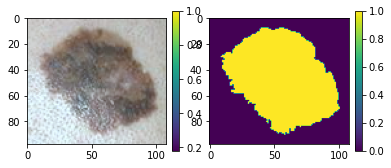

In [7]:
lesion_img, lesion_seg = fitz_ds.box_crop_lesion(fitz_ds.annotation_ids[4])
plt.subplot(1, 2, 1)
plt.imshow(lesion_img)
plt.colorbar(fraction=0.046, pad=0.04)
# plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(lesion_seg)
plt.colorbar(fraction=0.046, pad=0.04)
# plt.axis('off')
print(
    "Number of selected lesions away from the image border: {}".format(
        len(fitz_ds.annotation_ids)
    )
)
print("Number of fitz17k annotations: {}".format(len(fitz_ds.file_ids)))

In [8]:
mesh_filename = os.path.join(
    my_folders.bodytex_highres(), "221-m-u/model_highres_0_normalized.obj"
)

In [9]:
# For this particular test, we are only using a single lesion.
TEST_NAME = "tester"

# Comment this out if you want to include all the lesions.
# fitz_ds.annotation_ids = [fitz_ds.annotation_ids[4]]
len(fitz_ds.annotation_ids)

26

In [10]:
blended3d = Blended3d(
    mesh_filename=mesh_filename,
    # Directory to save the new textures.
    dir_blended_textures=my_folders.new_textures(),
    # Directory in this repo of bodytex nonskin face indexes.
    dir_nonskin_faces=None,  #'../data/bodytex/nonskinfaces',
    # Extension to add to the texture image filename.
    extension=TEST_NAME,
)
print(blended3d.subject_id)

221-m-u


In [11]:
nonskin_texture_mask_tensor = blended3d.nonskin_texture_mask(astensor=True)
original_texture_image_tensor = blended3d.texture_image(astensor=True)

In [12]:
mesh = load_objs_as_meshes([mesh_filename], device=device)
mesh_renderer = MeshRendererPyTorch3D(
    mesh=mesh,
    device=device,
)

In [13]:
# np.random.seed(42)
paster = PasteTextureImage(
    original_texture_image_tensor,
    nonskin_texture_mask_tensor,
    mesh_renderer,
    view_size,
)

# Stores the parameters of the pasted texture image.
selected_params = []

# How many lesions to paste on the texture image.
n_paste = 10

# Id to start the lesion masks.
lesion_mask_id = 1

# Repeat until paste `n_paste` number of lesions.
while lesion_mask_id <= n_paste:
    # Sample a new random view.
    paster.sample_next_view()

    # Select a random lesion.
    fitz_id = np.random.permutation(fitz_ds.annotation_ids)[0]
    lesion_img, lesion_seg = fitz_ds.box_crop_lesion(fitz_id)

    errors = paster.paste_on_texture(
        img=lesion_img, mask=lesion_seg, mask_id=lesion_mask_id, depth_diff_thresh=0.02
    )
    if errors:
        # Skip as unable to paste the lesion on the texture.
        print(errors)
    else:
        # Otherwise, store the parameters for the
        # subsequent steps in our pipeline.
        p = paster.view_params()
        p["fitz_id"] = fitz_id
        selected_params.append(p)
        print("Accepted lesion_mask_id = {}".format(lesion_mask_id))
        # Increment the mask_id
        lesion_mask_id += 1

Skipping sample 0 due to high depth change
Skipping sample 1 due to high depth change
Accepted lesion_mask_id = 1
Accepted lesion_mask_id = 2
Skipping sample 4 due to high depth change
Accepted lesion_mask_id = 3
Accepted lesion_mask_id = 4
Accepted lesion_mask_id = 5
Skipping sample 8 due to high depth change
Skipping sample 9 due to high depth change
Accepted lesion_mask_id = 6
Accepted lesion_mask_id = 7
Accepted lesion_mask_id = 8
Skipping sample 13 due to high depth change
Skipping sample 14 due to high depth change
Skipping sample 15 due to high depth change
Accepted lesion_mask_id = 9
Accepted lesion_mask_id = 10


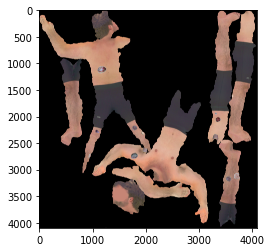

In [14]:
plt.imshow(paster.pasted_dilated_texture)

In [15]:
# Save the pasted texture image.
blended3d.save_pasted_texture_image(paster.pasted_texture, print_filepath=True)
blended3d.save_dilated_texture_image(paster.pasted_dilated_texture, print_filepath=True)

/mnt/d/data/3dbodytex-1.1-highres/3DBodyTex_nonskinfaces/3DBodyTex_nonskinfaces/221-m-u/model_highres_0_normalized_pasted_tester.png
/mnt/d/data/3dbodytex-1.1-highres/3DBodyTex_nonskinfaces/3DBodyTex_nonskinfaces/221-m-u/model_highres_0_normalized_dilated_tester.png


In [16]:
# Save the lesion mask for the texture image.
blended3d.save_lesion_texture_mask(paster.lesion_mask.squeeze(), print_filename=True)
blended3d.save_dilated_texture_mask(
    paster.lesion_dilated_mask.squeeze(), print_filepath=True
)

/mnt/d/data/3dbodytex-1.1-highres/3DBodyTex_nonskinfaces/3DBodyTex_nonskinfaces/221-m-u/lesion_mask_tester.png
/mnt/d/data/3dbodytex-1.1-highres/3DBodyTex_nonskinfaces/3DBodyTex_nonskinfaces/221-m-u/lesion_mask_dilated_tester.png


In [17]:
# Save the location parameters of the selected views.
final_params_df = pd.DataFrame(selected_params)
blended3d.save_lesion_params(final_params_df, print_filepath=True)
final_params_df.head()

/mnt/d/data/3dbodytex-1.1-highres/3DBodyTex_nonskinfaces/3DBodyTex_nonskinfaces/221-m-u/lesion_params_tester.csv


,look_at,normal,camera_pos,normal_weight,max_depth_diff,lesion_mask_id,fitz_id
0,"[0.5806335, 0.14949255, -0.03545352]","[0.07758307, 0.9626253, 0.25948694]","[0.6142211934362081, 0.5650966339960433, 0.076...",0.431636,0.004061,1,0d8457afebb67905127da37baece43d8
1,"[0.45160365, 0.16170503, 0.28515106]","[0.247675, 0.83573556, 0.49010524]","[0.5719915482555649, 0.5676953011439128, 0.523...",0.485668,0.005246,2,0d90cd2b2bf339a587dd7072372ff186
2,"[1.432153, 0.083884835, -0.112745464]","[-0.053761363, -0.4393269, -0.8967171]","[1.4013192267403298, -0.1687995512137465, -0.6...",0.575390,0.008733,3,0b40c010e442d29b496fa8368746b02a
3,"[1.5562655, 0.08823033, -0.19880952]","[0.5676358, -0.78548473, 0.24658325]","[1.7942757827749958, -0.24088591327756398, -0....",0.419125,0.016574,4,1a3485252a20ba5b11e3958881f21b4e
4,"[0.3363813, 0.08113881, -0.07177762]","[-0.09212656, -0.8972659, 0.4317712]","[0.2812358704727805, -0.4568234658374547, 0.18...",0.599669,0.006802,5,0ef0d6fa3124b76205a8d514b22fafaa


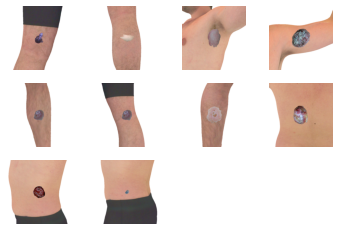

In [18]:
# Number of rows and columns to show all the pasted lesions.
# You might have to adjust this.
n_rows = np.floor(np.sqrt(len(final_params_df))).astype(int)
n_cols = np.ceil(np.sqrt(len(final_params_df))).astype(int)

plt_idx = 1
for _, params in final_params_df.iterrows():
    paster.set_renderer_view(
        face_idx=None,
        surface_offset_range=None,
        look_at=params.look_at,
        camera_pos=params.camera_pos,
    )

    lesion_img, lesion_seg = fitz_ds.box_crop_lesion(
        params.fitz_id,
        force_even_dims=True,
        asfloat=True,
    )
    paster.init_target_lesion(lesion_img, lesion_seg)
    paste_img = paster.pasted_image()
    plt.subplot(n_rows, n_cols, plt_idx)
    plt.imshow(paste_img)
    plt.axis("off")
    plt_idx += 1

In [19]:
len(final_params_df.fitz_id.unique())

9